# 1. Datengrundlage
## 1.1 Import

In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime

current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
data_path = Path("../../data/")

file_real = data_path / "20250301_data_20250421_133906_final_10_train.csv"
df_real = pd.read_csv(file_real, low_memory=False) # Use low_memory=False to prevent dtype issues with large files
path_real = Path(file_real)
# print(df_real.head())

file_synth = data_path / "20250301_data_20250421_133906_final_synth_10_epochs.csv"
df_synth = pd.read_csv(file_synth, low_memory=False) # Use low_memory=False to prevent dtype issues with large files
path_synth = Path(file_synth)
# print(df_synth.head())

file_holdout = data_path / "20250301_data_20250421_133906_final_10_holdout.csv"
df_holdout = pd.read_csv(file_holdout, low_memory=False) # Use low_memory=False to prevent dtype issues with large files
path_holdout = Path(file_holdout)


## 1.2 Col Description & Target

In [9]:
numerical_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
categorical_cols = ['icu_admission_24h', 'gender', 'ethnicity', 'consciousness_level','news_score', 'night_arrival', 'weekend_arrival','chief_complaint', 'icd_block']

In [3]:
use_subset = True
subset_size = 1000

In [4]:
if use_subset:
    df_real     = df_real.sample(n=subset_size, random_state=42)
    df_synth    = df_synth.sample(n=subset_size, random_state=42)
    df_holdout  = df_holdout.sample(n=subset_size, random_state=42)

# First Try, numeric only

In [5]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

def median_distance_to_closest_record(real_data, synthetic_data, cat_cols=None, metric='euclidean'):
    # Separate numerical and categorical columns
    if cat_cols is None:
        cat_cols = []
    num_cols = [col for col in real_data.columns if col not in cat_cols]
    
    # Convert to numpy arrays
    X_real = real_data[num_cols].to_numpy(dtype=float)
    X_synt = synthetic_data[num_cols].to_numpy(dtype=float)
    
    # Compute distances: synthetic → real
    dist_mutual = cdist(X_synt, X_real, metric=metric)
    min_dist_mutual = dist_mutual.min(axis=1)
    
    # Compute distances: real → real (excluding self-distances)
    dist_internal = cdist(X_real, X_real, metric=metric)
    np.fill_diagonal(dist_internal, np.inf)
    min_dist_internal = dist_internal.min(axis=1)
    
    # Medians
    mut_nn = np.median(min_dist_mutual)
    int_nn = np.median(min_dist_internal)
    
    # Calculate DCR
    if int_nn == 0 and mut_nn == 0:
        dcr = 1.0
    elif int_nn == 0:
        dcr = 0.0
    else:
        dcr = mut_nn / int_nn
    
    return {'mDCR': dcr}




In [6]:
result = median_distance_to_closest_record(df_real, df_synth, cat_cols=categorical_cols, metric='euclidean')
print(result)

{'mDCR': np.float64(1.2691550972124614)}


# 2nd Try, Gower

In [ ]:
import numpy as np
import pandas as pd

def median_distance_to_closest_record(real_data: pd.DataFrame,
                                      synthetic_data: pd.DataFrame,
                                      cat_cols: list[str] | None = None) -> dict[str, float]:
    """
    Berechnet die mDCR (median Distance-to-Closest-Record) auf Basis der Gower-Distanz,
    d.h. numerische Features werden normiert nach ihrer Range, kategoriale als 0/1-Unterschiede.
    
    real_data: DataFrame mit den Originaldaten
    synthetic_data: DataFrame mit den synthetischen Daten (selben Spalten)
    cat_cols: Liste der kategorialen Spaltennamen
    """
    if cat_cols is None:
        cat_cols = []
    # alle anderen Spalten sind numerisch
    num_cols = [c for c in real_data.columns if c not in cat_cols]

    # Arrays für numerische und kategoriale Daten
    Xr_num = real_data[num_cols].to_numpy(dtype=float)
    Xs_num = synthetic_data[num_cols].to_numpy(dtype=float)

    # Wertebereiche (max–min) pro numerischer Spalte; Null-Bereiche auf 1 setzen
    ranges = (real_data[num_cols].max() - real_data[num_cols].min()).to_numpy(dtype=float)
    ranges[ranges == 0] = 1.0

    # Wenn vorhanden: kategoriale Arrays
    if cat_cols:
        Xr_cat = real_data[cat_cols].to_numpy()
        Xs_cat = synthetic_data[cat_cols].to_numpy()
    else:
        # Platzhalter-Arrays mit 0 Spalten
        Xr_cat = np.empty((len(real_data), 0))
        Xs_cat = np.empty((len(synthetic_data), 0))

    # Anzahl Features gesamt
    n_num = Xr_num.shape[1]
    n_cat = Xr_cat.shape[1]
    n_feat = n_num + n_cat

    # --- 1) Distanz von jeder synthetischen Beobachtung zu allen Real-Daten ---
    # numerische Abweichung: |x - y| / range
    diff_num_mutual = np.abs(Xs_num[:, None, :] - Xr_num[None, :, :]) / ranges
    # kategoriale Abweichung: 1 wenn verschieden, sonst 0
    diff_cat_mutual = (Xs_cat[:, None, :] != Xr_cat[None, :, :]).astype(float)

    # Gower-Distanz = (Summe aller Feature-Distanzen) / Anzahl Features
    dist_mutual = (diff_num_mutual.sum(axis=2) + diff_cat_mutual.sum(axis=2)) / n_feat
    min_dist_mutual = dist_mutual.min(axis=1)

    # --- 2) Distanz intern: Real-Daten untereinander (ohne Selbstvergleich) ---
    diff_num_internal = np.abs(Xr_num[:, None, :] - Xr_num[None, :, :]) / ranges
    diff_cat_internal = (Xr_cat[:, None, :] != Xr_cat[None, :, :]).astype(float)
    dist_internal = (diff_num_internal.sum(axis=2) + diff_cat_internal.sum(axis=2)) / n_feat

    # Selbstdistanz unendlich setzen, damit min() sie nicht auswählt
    np.fill_diagonal(dist_internal, np.inf)
    min_dist_internal = dist_internal.min(axis=1)

    # --- 3) Median und DCR ---
    mut_nn = np.median(min_dist_mutual)
    int_nn = np.median(min_dist_internal)

    if int_nn == 0 and mut_nn == 0:
        dcr = 1.0
    elif int_nn == 0:
        dcr = 0.0
    else:
        dcr = mut_nn / int_nn

    return {'mDCR': dcr}






{'mDCR': np.float64(0.9000000000000001)}


In [10]:
result = median_distance_to_closest_record(df_real, df_synth, cat_cols=categorical_cols)
print(result)

{'mDCR': np.float64(1.1679597208863024)}


In [11]:
def median_distance_to_closest_record_extended(real_data: pd.DataFrame,
                                              synthetic_data: pd.DataFrame,
                                              cat_cols: list[str] | None = None) -> dict[str, float]:
    # identisch zu deinem bisherigen Code …
    if cat_cols is None:
        cat_cols = []
    num_cols = [c for c in real_data.columns if c not in cat_cols]

    Xr_num = real_data[num_cols].to_numpy(dtype=float)
    Xs_num = synthetic_data[num_cols].to_numpy(dtype=float)

    ranges = (real_data[num_cols].max() - real_data[num_cols].min()).to_numpy(dtype=float)
    ranges[ranges == 0] = 1.0

    if cat_cols:
        Xr_cat = real_data[cat_cols].to_numpy()
        Xs_cat = synthetic_data[cat_cols].to_numpy()
    else:
        Xr_cat = np.empty((len(real_data), 0))
        Xs_cat = np.empty((len(synthetic_data), 0))

    n_num = Xr_num.shape[1]
    n_cat = Xr_cat.shape[1]
    n_feat = n_num + n_cat

    diff_num_mutual = np.abs(Xs_num[:, None, :] - Xr_num[None, :, :]) / ranges
    diff_cat_mutual = (Xs_cat[:, None, :] != Xr_cat[None, :, :]).astype(float)
    dist_mutual = (diff_num_mutual.sum(axis=2) + diff_cat_mutual.sum(axis=2)) / n_feat
    min_dist_mutual = dist_mutual.min(axis=1)

    diff_num_internal = np.abs(Xr_num[:, None, :] - Xr_num[None, :, :]) / ranges
    diff_cat_internal = (Xr_cat[:, None, :] != Xr_cat[None, :, :]).astype(float)
    dist_internal = (diff_num_internal.sum(axis=2) + diff_cat_internal.sum(axis=2)) / n_feat
    np.fill_diagonal(dist_internal, np.inf)
    min_dist_internal = dist_internal.min(axis=1)

    mut_nn = np.median(min_dist_mutual)
    int_nn = np.median(min_dist_internal)

    if int_nn == 0 and mut_nn == 0:
        dcr = 1.0
    elif int_nn == 0:
        dcr = 0.0
    else:
        dcr = mut_nn / int_nn

    return {'mDCR': dcr, 
            'min_dist_mutual': min_dist_mutual, 
            'min_dist_internal': min_dist_internal}


In [12]:
result = median_distance_to_closest_record_extended(df_real, df_synth, cat_cols=categorical_cols)
print(result)

{'mDCR': np.float64(1.1679597208863024), 'min_dist_mutual': array([0.10939556, 0.12996135, 0.0774607 , 0.16473378, 0.19628591,
       0.12701542, 0.20478724, 0.09146336, 0.1730286 , 0.21360743,
       0.18643229, 0.14776212, 0.18936272, 0.15823572, 0.15158291,
       0.16949019, 0.1546248 , 0.16161032, 0.21180036, 0.21284194,
       0.16135085, 0.15075668, 0.16492911, 0.15177098, 0.13748516,
       0.17888748, 0.17271697, 0.18402367, 0.16406153, 0.18031097,
       0.2165091 , 0.17477392, 0.0694278 , 0.17880038, 0.15740652,
       0.22393871, 0.14704092, 0.13756568, 0.19310365, 0.15661791,
       0.10585765, 0.20947811, 0.1872323 , 0.22010211, 0.120163  ,
       0.05639768, 0.10273408, 0.22282767, 0.1559736 , 0.15591442,
       0.17185867, 0.11029761, 0.16396081, 0.15965929, 0.12565337,
       0.17203227, 0.181446  , 0.16423987, 0.05236585, 0.1634413 ,
       0.1959567 , 0.24255115, 0.18978701, 0.35769888, 0.18374231,
       0.14652925, 0.21668606, 0.23854942, 0.17788077, 0.16859239,
  

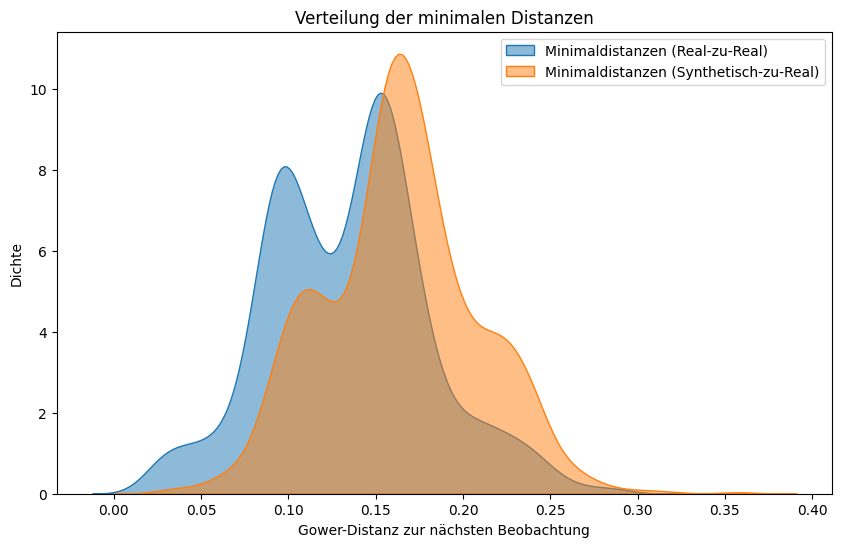

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Beispielaufruf der erweiterten Funktion:
result = median_distance_to_closest_record_extended(df_real, df_synth, cat_cols=categorical_cols)

min_dist_mutual = result['min_dist_mutual']
min_dist_internal = result['min_dist_internal']

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(min_dist_internal, label='Minimaldistanzen (Real-zu-Real)', fill=True, alpha=0.5)
sns.kdeplot(min_dist_mutual, label='Minimaldistanzen (Synthetisch-zu-Real)', fill=True, alpha=0.5)
plt.xlabel('Gower-Distanz zur nächsten Beobachtung')
plt.ylabel('Dichte')
plt.title('Verteilung der minimalen Distanzen')
plt.legend()
plt.show()


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_distance_distribution(min_dist_mutual: np.ndarray,
                               min_dist_internal: np.ndarray,
                               mode: str = 'min'):
    """
    Visualisiert die Distanzen als KDE-Plot.
    
    mode: 'min' (zeigt alle Minimaldistanzen) oder 'median' (zeigt nur den Median jeder Gruppe als Punkt).
    """
    plt.figure(figsize=(10, 6))
    
    if mode == 'min':
        # Verteilung aller Minimaldistanzen plotten
        sns.kdeplot(min_dist_internal, label='Minimaldistanzen (Real-zu-Real)', fill=True, alpha=0.5)
        sns.kdeplot(min_dist_mutual, label='Minimaldistanzen (Synthetisch-zu-Real)', fill=True, alpha=0.5)
        plt.xlabel('Gower-Distanz zur nächsten Beobachtung')
        plt.ylabel('Dichte')
        plt.title('Verteilung der minimalen Distanzen')
        
    elif mode == 'median':
        # Nur die Mediane als vertikale Linien oder Punkte plotten
        median_internal = np.median(min_dist_internal)
        median_mutual = np.median(min_dist_mutual)
        
        plt.axvline(median_internal, color='blue', linestyle='--', label=f'Median (Real-zu-Real): {median_internal:.3f}')
        plt.axvline(median_mutual, color='orange', linestyle='--', label=f'Median (Synthetisch-zu-Real): {median_mutual:.3f}')
        
        plt.xlabel('Gower-Distanz zur nächsten Beobachtung')
        plt.ylabel('Dichte (nicht dargestellt)')
        plt.title('Mediane der minimalen Distanzen')
        
    else:
        raise ValueError("mode must be 'min' or 'median'")
    
    plt.legend()
    plt.show()


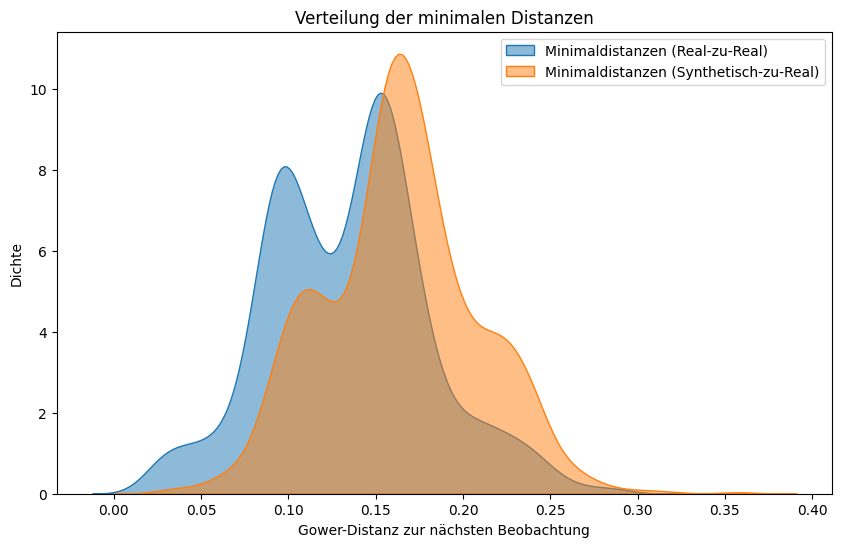

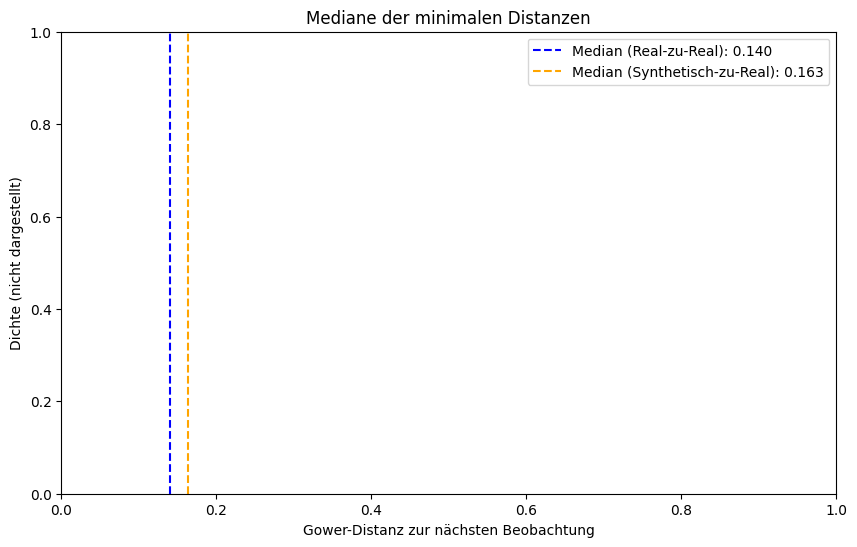

In [16]:
# Nehme die Rückgabe aus deiner erweiterten DCR-Funktion
result = median_distance_to_closest_record_extended(df_real, df_synth, cat_cols=categorical_cols)

# Minimaldistanzen-Plot
plot_distance_distribution(result['min_dist_mutual'], result['min_dist_internal'], mode='min')

# Median-Plot
plot_distance_distribution(result['min_dist_mutual'], result['min_dist_internal'], mode='median')


# -----------

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

# --- STEP 1: Laden oder übernehmen deiner DataFrames ---
# df_real = pd.read_csv('real_data.csv')
# df_synth = pd.read_csv('synth_data.csv')

# --- STEP 2: Auswahl numerischer Features ---
numeric_features = [
    'age', 'temperature', 'heart_rate', 'respiratory_rate', 
    'oxygen_saturation', 'systolic_bp', 'diastolic_bp'
]

# Prüfen, ob alle Features vorhanden sind
for feat in numeric_features:
    if feat not in df_real.columns:
        raise ValueError(f"Feature {feat} fehlt in df_real")
    if feat not in df_synth.columns:
        raise ValueError(f"Feature {feat} fehlt in df_synth")

# --- STEP 3: Standardisierung der numerischen Features ---
scaler = StandardScaler()
real_scaled = scaler.fit_transform(df_real[numeric_features])
synth_scaled = scaler.transform(df_synth[numeric_features])

# --- STEP 4: Berechnung der paarweisen Distanzen ---
# Jede synthetische Zeile wird mit allen realen verglichen
dist_matrix = pairwise_distances(synth_scaled, real_scaled, metric='euclidean')

# Für jeden synthetischen Datensatz: Distanz zum nächstgelegenen realen Datensatz
dcr_values = dist_matrix.min(axis=1)

# --- STEP 5: Statistische Zusammenfassung ---
print("Distance to Closest Record (DCR) - Zusammenfassung:")
print(f"Anzahl: {len(dcr_values)}")
print(f"Mittelwert: {np.mean(dcr_values):.4f}")
print(f"Median: {np.median(dcr_values):.4f}")
print(f"Min: {np.min(dcr_values):.4f}")
print(f"Max: {np.max(dcr_values):.4f}")

# --- STEP 6: Visualisierung ---

plt.figure(figsize=(12, 5))

# Histogramm
plt.subplot(1, 2, 1)
plt.hist(dcr_values, bins=30, edgecolor='black')
plt.xlabel('Distance to Closest Record (DCR)')
plt.ylabel('Häufigkeit')
plt.title('Histogramm der DCR-Werte')

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(dcr_values, vert=False)
plt.xlabel('Distance to Closest Record (DCR)')
plt.title('Boxplot der DCR-Werte')

plt.tight_layout()
plt.show()
